In [1]:
from sqlalchemy import create_engine
import pandas as pd
import os
from dotenv import load_dotenv
import sqlalchemy
from sqlalchemy import create_engine, text
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats 
from sqlalchemy.exc import OperationalError, ProgrammingError 
from datetime import datetime, timedelta
from scipy.stats import ttest_ind
from IPython.display import display



load_dotenv('test.env')
load_dotenv('test.env', override=True)

sql_username = os.getenv('DB_USER')
sql_password = os.getenv('DB_PASSWORD')
sql_host = os.getenv('DB_HOST')
sql_database = os.getenv('DB_NAME')

sql_username

# with SSL off

url_string = f"mysql+pymysql://{sql_username}:{sql_password}@{sql_host}:3306/{sql_database}"

conn = create_engine(url_string)


selected_metrics = [
    'Jump Height(m)',
    'Avg. Braking Force(N)',
    'Avg. Propulsive Force(N)',
    'Avg. Braking Power(W)',
    'Braking Phase(s)'
]

query = f"""
SELECT *
FROM research_experiment_refactor_test
WHERE metric IN ({','.join([f"'{m}'" for m in selected_metrics])})
"""
df = pd.read_sql(query, conn)

display(df.head())



,id,playername,timestamp,device,metric,value,team,session_type,session_description,function_description,data_source,created_at
0,1,PLAYER_1175,2018-10-15 19:27:41,hawkins,Avg. Braking Force(N),1546.3816,Team: Stony Brook,None,None,None,hawkins,2025-10-21 16:46:54
1,92,PLAYER_070,2018-10-15 20:42:36,hawkins,Avg. Braking Force(N),1160.1111,"Group: Athletic Performance Staff, Team: Stony...",None,None,None,hawkins,2025-10-21 16:46:54
2,140,PLAYER_594,2018-10-16 14:06:30,hawkins,Avg. Braking Force(N),835.0986,"Group: Athletic Performance Staff, Team: Stony...",None,None,None,hawkins,2025-10-21 16:46:54
3,188,PLAYER_070,2018-10-16 14:11:46,hawkins,Avg. Braking Force(N),1252.6244,"Group: Athletic Performance Staff, Team: Stony...",None,None,None,hawkins,2025-10-21 16:46:54
4,236,PLAYER_070,2018-10-16 14:31:21,hawkins,Avg. Braking Force(N),1084.8346,"Group: Athletic Performance Staff, Team: Stony...",None,None,None,hawkins,2025-10-21 16:46:54


Metrics in database: ['Avg. Braking Force(N)' 'Avg. Braking Power(W)'
 'Avg. Braking Velocity(m/s)' 'Avg. Landing Force(N)'
 'Avg. Propulsive Force(N)' 'Avg. Propulsive Power(W)'
 'Avg. Propulsive Velocity(m/s)' 'Avg. Relative Propulsive Force(%)'
 'Avg. Relative Propulsive Power(W/kg)' 'Braking Net Impulse(N.s)'
 'Braking Phase %' 'Braking Phase(s)' 'Braking RFD(N/s)'
 'Countermovement Depth(m)' 'Flight Time(s)' 'Impulse Ratio'
 'Jump Height(m)' 'Landing Stiffness(N/m)' 'L|R Avg. Braking Force(%)'
 'L|R Avg. Braking RFD(%)' 'L|R Avg. Landing Force(%)'
 'L|R Avg. Propulsive Force(%)' 'L|R Braking Impulse Index(%)'
 'L|R Landing Impulse Index(%)' 'L|R Peak Braking Force(%)'
 'L|R Peak Landing Force(%)' 'L|R Peak Propulsive Force(%)'
 'L|R Propulsive Impulse Index(%)' 'Peak Braking Force(N)'
 'Peak Braking Power(W)' 'Peak Landing Force(N)'
 'Peak Propulsive Force(N)' 'Peak Propulsive Power(W)'
 'Peak Velocity(m/s)' 'Positive Net Impulse(N.s)'
 'Propulsive Net Impulse(N.s)' 'Propulsive Ph

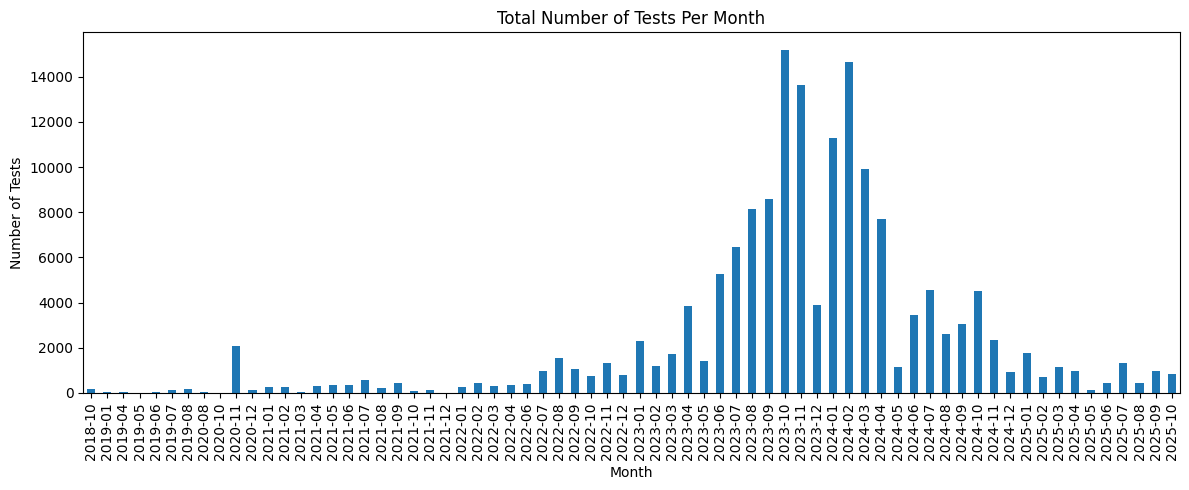


Breakdown by data source:


data_source,hawkins,kinexon,vald
Month,,,
2018-10,162,0,0
2019-01,27,0,0
2019-04,57,0,0
2019-05,5,0,0
2019-06,30,0,0


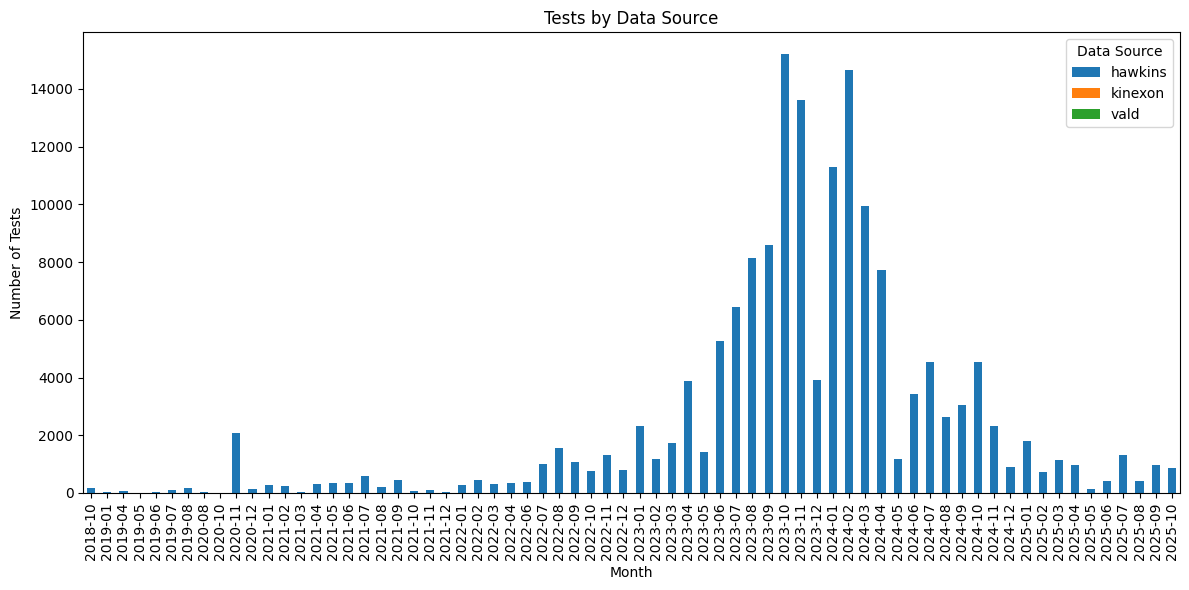

In [6]:

selected_metrics = [
    "Jump Height(m)",
    "Avg. Braking Force(N)",
    "Avg. Propulsive Force(N)",
    "Avg. Braking Power(W)",
    "Braking Phase(s)"
]
data_sources = ["hawkins", "kinexon", "vald"]


query = """
SELECT playername, team, metric, value, timestamp, data_source
FROM research_experiment_refactor_test
"""
df = pd.read_sql(query, conn)

# --- See what metrics and data sources are actually in the DB ---
print("Metrics in database:", df["metric"].unique())
print("Data sources in database:", df["data_source"].unique())

# --- Filter for the metrics and sources we care about ---
df = df[df["metric"].isin(selected_metrics)]
df = df[df["data_source"].isin(data_sources)]

# --- Check if any data remains ---
if df.empty:
    print("No data found for the selected metrics or data sources. Cannot plot.")
else:
    # --- Convert timestamp to datetime and make a 'Month' column ---
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])  # remove invalid dates
    df["Month"] = df["timestamp"].dt.to_period("M")

    # --- Total tests per month ---
    tests_per_month = df.groupby("Month").size()
    print("\nTotal tests per month:")
    print(tests_per_month)

    if not tests_per_month.empty:
        plt.figure(figsize=(12,5))
        tests_per_month.plot(kind="bar")
        plt.title("Total Number of Tests Per Month")
        plt.xlabel("Month")
        plt.ylabel("Number of Tests")
        plt.tight_layout()
        plt.show()
    else:
        print("No tests to plot for total tests per month.")

    # --- Breakdown by data source ---
    source_counts = df.groupby(["Month","data_source"]).size().unstack(fill_value=0)
    
    # Ensure all data sources appear in the columns
    for src in data_sources:
        if src not in source_counts.columns:
            source_counts[src] = 0
    source_counts = source_counts[data_sources]  # reorder

    print("\nBreakdown by data source:")
    display(source_counts.head())

    if not source_counts.empty:
        source_counts.plot(kind="bar", stacked=True, figsize=(12,6))
        plt.title("Tests by Data Source")
        plt.xlabel("Month")
        plt.ylabel("Number of Tests")
        plt.legend(title="Data Source")
        plt.tight_layout()
        plt.show()
